# Домашнее задание 4

В последнем практическом задании мы потренируемся в построении VaR- и ES-кривой для небольшого портфеля. Каждый актив (акцию или валюту) далее будем называть инструментом.

### 1) Загрузка данных (бесценно)

* Представьте, что вы инвестор и собираете инвестиционный портфель.

* Загрузите данные по трём любым акциям и двум любым валютам за последние 10 лет. Акции и валюты выберите на ваш вкус, но интереснее будет взять что-то кроме евро/доллара/акций гугла.

* Можно использовать YachooFinance либо другие источники при желании.

* Переведите цены в доходности. Можно использовать разности или процентные изменения на выбор.



In [249]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("bmh")
# plt.style.use(['seaborn-darkgrid'])
plt.rcParams['font.family'] = 'DejaVu Sans'
# %config InlineBackend.figure_formats=["png"]

import warnings
warnings.filterwarnings("ignore")

In [250]:
import yfinance as yf
tickers = ["7203.T", "SBER.ME", "TATN.ME", "RUB=X", "JPY=X"]

data = yf.download(tickers, start="2014-01-01", end="2024-12-31", group_by='ticker', auto_adjust=True)
close_prices = pd.DataFrame({ticker: data[ticker]["Close"] for ticker in tickers})
close_prices.rename(columns={"7203.T": "Toyota", "SBER.ME": "Sberbank", "TATN.ME": "Tatneft", "RUB=X": "RUB", "JPY=X": "JPY"}, inplace=True)
close_prices = close_prices.dropna()

returns = close_prices.pct_change().dropna()
returns.head(3)

[*********************100%***********************]  5 of 5 completed


,Toyota,Sberbank,Tatneft,RUB,JPY
Date,,,,,
2014-01-08,0.000000,-0.004360,-0.016367,-0.001863,-0.001906
2014-01-09,-0.004762,-0.002342,0.008066,-0.000468,0.001261
2014-01-10,0.003190,0.014699,0.006492,0.001819,-0.000134


In [251]:
returns.shape

(1987, 5)

In [252]:
tickers = list(returns.columns)
tickers

['Toyota', 'Sberbank', 'Tatneft', 'RUB', 'JPY']

### 2. Визуализация.

#### 2.1 (0.5 балла)
Изобразите парные диаграммы рассеяния (scatterplot) для всех комбинаций инструментов. В каких парах наблюдается связь, а в каких нет? Кратко интерпретируйте зависимость по одному примеру из предыдущего вопроса (один где есть зависимость, другой где нет). Если во всех парах есть зависимость (или во всех нет), то достаточно одного примера.

<Figure size 700x700 with 0 Axes>

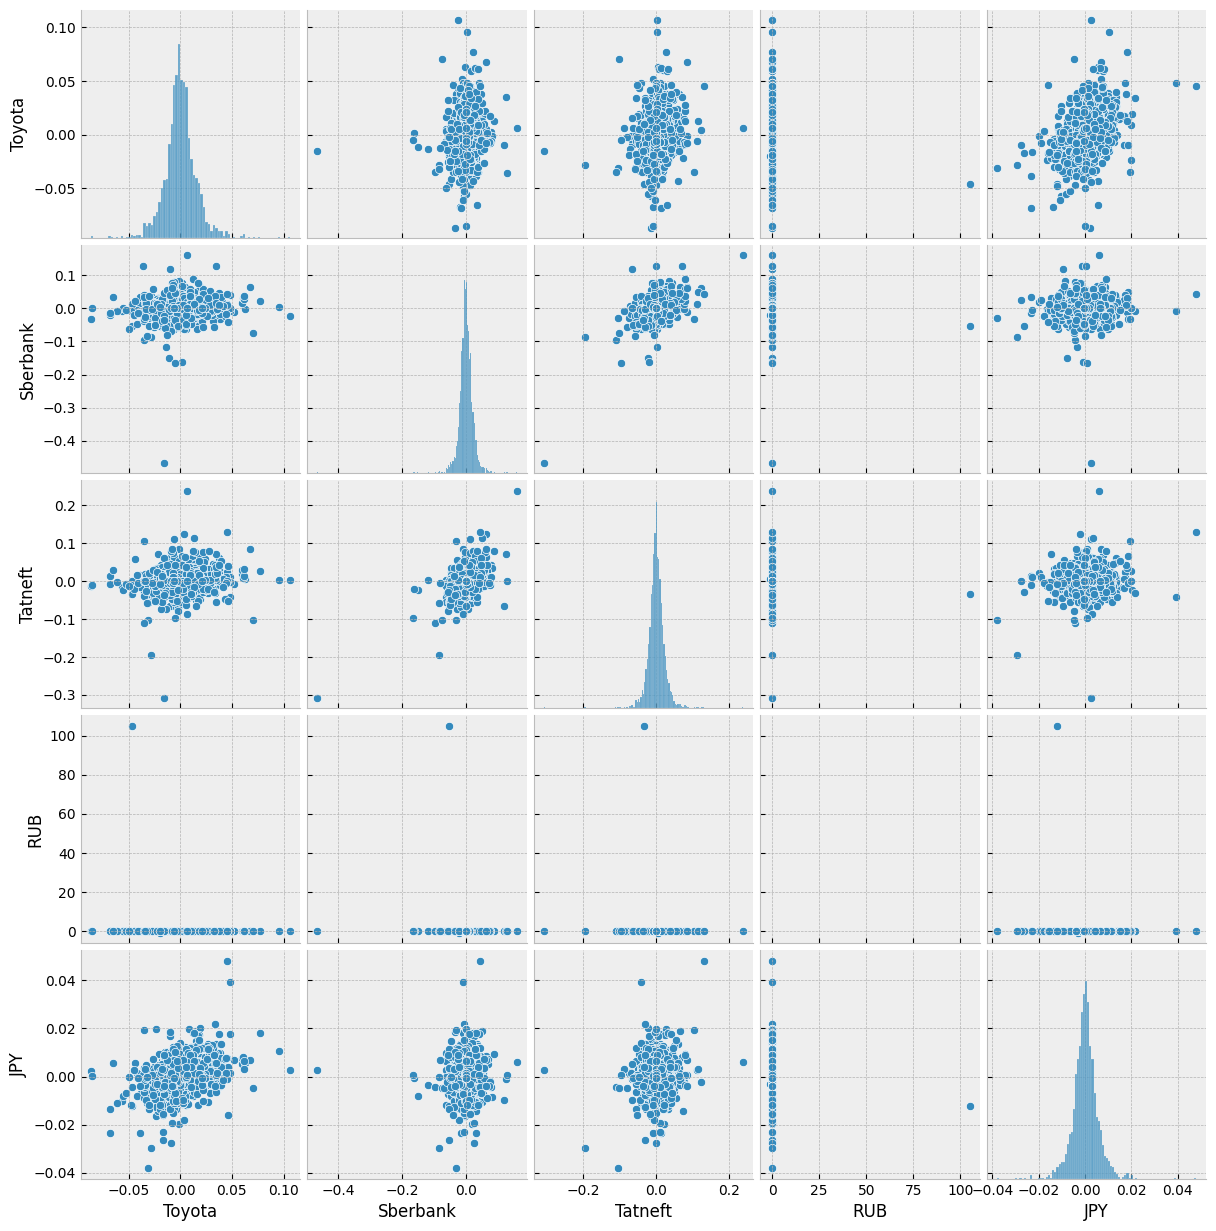

In [253]:
from pandas.plotting import scatter_matrix

fig = plt.figure(figsize=(7, 7))

sns.pairplot(returns[tickers])

plt.show();

#### 2.2 (1 балл)
Изобразите гистограмму распределения каждого инструмента, наложив на неё оценённое нормальное распределение. Прокомментируйте характеристики распределения доходностей.

In [93]:
from scipy.stats import norm

In [94]:
returns['RUB'] = returns['RUB'].where(returns['RUB'] < 1)

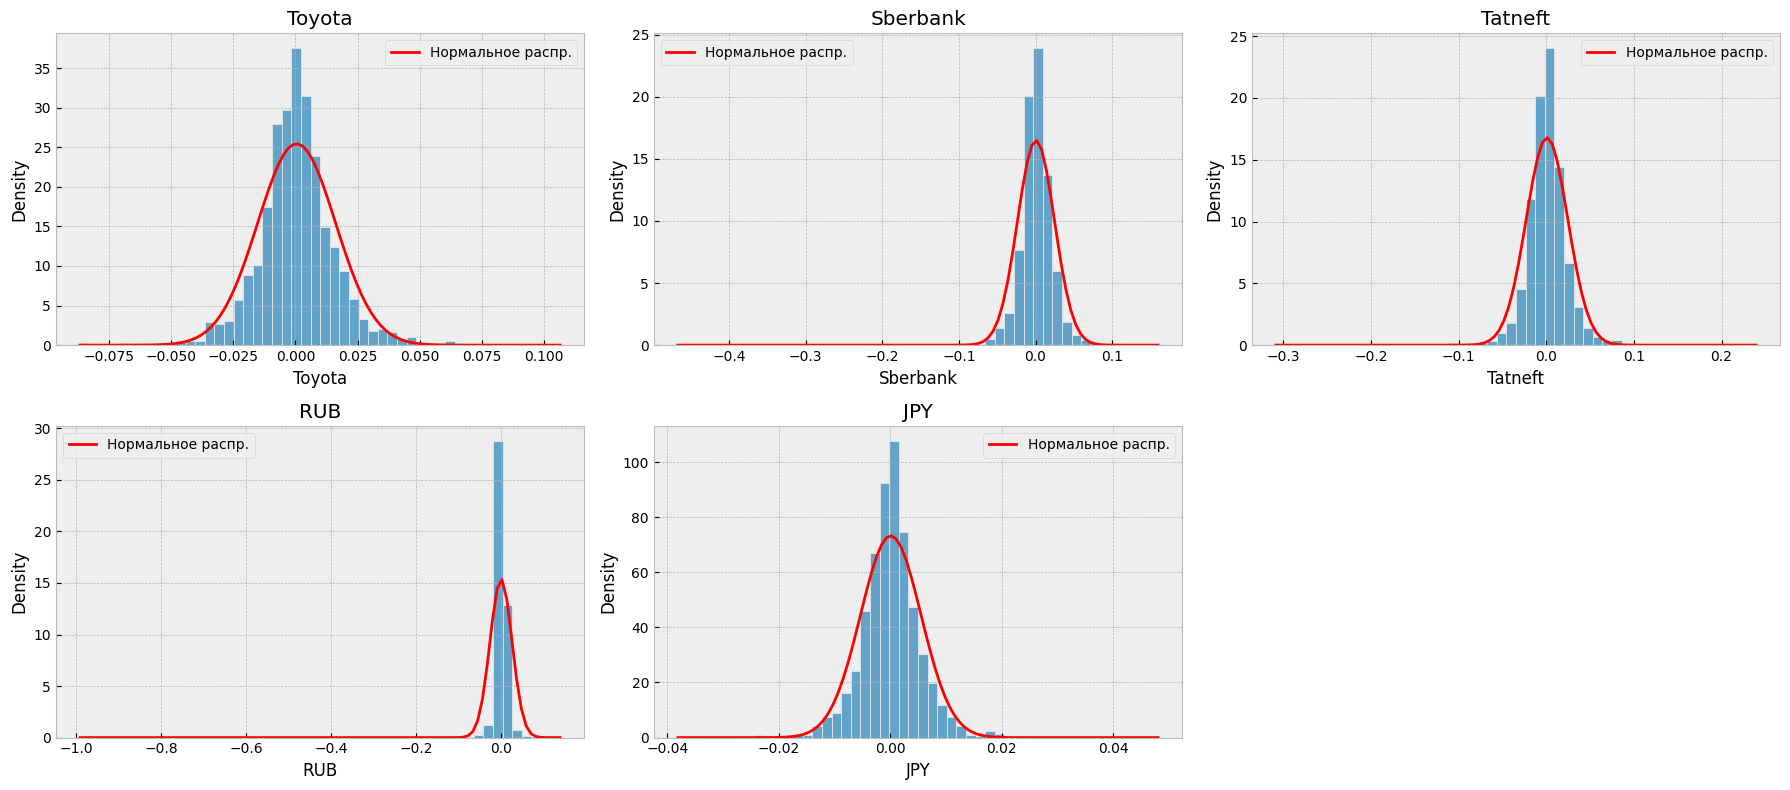

In [95]:
cols = returns.columns
fig, axes = plt.subplots(nrows=(len(cols)+2)//3, ncols=3, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(cols):
    data = returns[col]
    mu, std = data.mean(), data.std()
    x = np.linspace(data.min(), data.max(), 100)
    pdf = norm.pdf(x, mu, std)

    sns.histplot(data, bins=50, stat='density', ax=axes[i])
    axes[i].plot(x, pdf, 'r', label='Нормальное распр.')
    axes[i].set_title(col)
    axes[i].legend()
    axes[i].grid(True)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


1. Toyota - распределение похоже на нормальное: симметрично, без выраженных хвостов.
2. Sberbank - сильно вытянутый левый хвост и высокая пикообразность — типичное отклонение от нормальности. Природа длинного хвоста понятна.
3. Tatneft - картина аналогична: центральная часть узкая, хвосты более толстые.
4. RUB (USD/RUB) - виден выброс: возможно, исторический девальвационный скачок. Точнее был виден ранее, потом удалила его. Распределение сильно несимметрично и пикообразно.
5. JPY (USD/JPY) - наверное ближе всех к нормальному распределению.

#### 2.3 (0.5 балла)
В качестве весов портфеля используйте веса на момент покупки (как в семинаре). Изобразите  гистограмму распределения доходностей портфеля, наложив на неё оценённое нормальное распределение. Прокомментируйте характеристики распределения доходностей.

In [96]:
selected_companies = ['Toyota', 'Sberbank', 'Tatneft']

In [97]:
w = 1 / close_prices.iloc[0]
w = w / w.sum()
portfolio_real_returns = np.dot(returns.values, w)

w_temp = 1 / close_prices[selected_companies].iloc[0]
w_temp = w_temp / w_temp.sum()
portfolio_real_returns_selected = np.dot(returns[selected_companies].values, w_temp)
portfolio_real_returns_selected = pd.Series(portfolio_real_returns_selected, index=returns.index)

print(w)

Toyota      0.017549
Sberbank    0.228743
Tatneft     0.133657
RUB         0.471119
JPY         0.148931
Name: 2014-01-06 00:00:00, dtype: float64


In [98]:
print(w_temp)

Toyota      0.046188
Sberbank    0.602035
Tatneft     0.351777
Name: 2014-01-06 00:00:00, dtype: float64


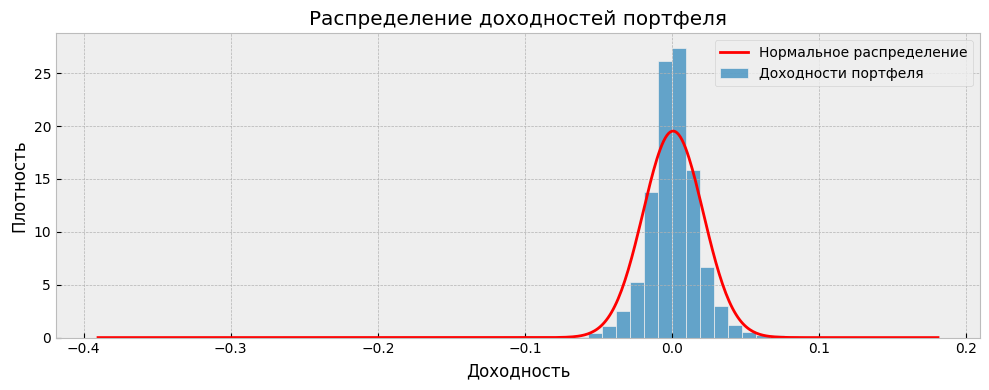

In [99]:
mu = portfolio_real_returns_selected.mean()
std = portfolio_real_returns_selected.std()

x = np.linspace(portfolio_real_returns_selected.min(), portfolio_real_returns_selected.max(), 500)
pdf = norm.pdf(x, mu, std)

plt.figure(figsize=(10, 4))
sns.histplot(portfolio_real_returns_selected, bins=60, stat='density', label='Доходности портфеля')
plt.plot(x, pdf, 'r-', lw=2, label='Нормальное распределение')
plt.title("Распределение доходностей портфеля")
plt.xlabel("Доходность")
plt.ylabel("Плотность")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Нормальное распределение в целом неплохо приближает форму, но:
плохо захватывает хвостовые риски может недооценивать VaR / ES. Видим достаточно длинный левый хвост.


#### 2.4 (0.5 балла)
Придумайте, опишите и примените альтернативную стратегию взвешивания. Поясните, почему она имеет смысл.

Чем менее волатилен актив, тем больше вес в портфеле. Логика: стабильные активы дают более предсказуемый вклад, а значит они безопаснее и консервативному инвестору есть смысл составлять именно такой портфель.

In [100]:
volatility = returns[selected_companies].std()

w_inv_vol = 1 / volatility
w_inv_vol = w_inv_vol / w_inv_vol.sum()

portfolio_risk_weighted = returns[selected_companies].dot(w_inv_vol)

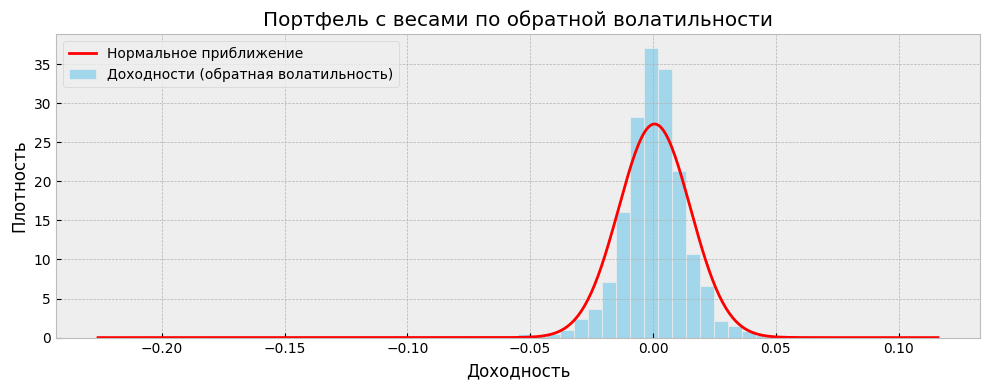

In [101]:
mu = portfolio_risk_weighted.mean()
std = portfolio_risk_weighted.std()
x = np.linspace(portfolio_risk_weighted.min(), portfolio_risk_weighted.max(), 500)
pdf = norm.pdf(x, mu, std)

plt.figure(figsize=(10, 4))
sns.histplot(portfolio_risk_weighted, bins=60, stat='density', color='skyblue', label='Доходности (обратная волатильность)')
plt.plot(x, pdf, 'r-', lw=2, label='Нормальное приближение')
plt.title("Портфель с весами по обратной волатильности")
plt.xlabel("Доходность")
plt.ylabel("Плотность")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [102]:
print("Веса при обратной волатильности:")
print(w_inv_vol.round(3))

Веса при обратной волатильности:
Toyota      0.433
Sberbank    0.281
Tatneft     0.286
dtype: float64


### 3. Анализ отдельных инструментов. (2 балла, по 0.4 за инструмент)

* Подберите для каждого инструмента наиболее подходящее маржинальное распределение. Можно использовать всё, что есть в scipy, а также garch-модель.
* Для каждого результата изобразите калибровочную кривую (qq-plot), а также наложите оценённую функцию плотности на гистограмму распределения доходности. Прокомментируйте графики.

Обратите внимание, что для GARCH-модели подход будет особенный в плане построения qq-plot и гистограммы. Как мы помним из формулы ниже, дисперсия у нас представлена умножением условной волатильности на распределение. Поэтому на qq-plot и гистограмме нужно будет визуализировать стандартизированные остатки против функции плотности $\epsilon$.

$$r_{t+1} = \mu_t  + \sqrt{h_t}\epsilon_t \text{  with  } \epsilon_t \sim N(0, 1)$$


NB! Постарайтесь подобрать распределение как можно точнее, от этого существенно зависит итоговый результат.


### Стьюдент

In [103]:
import scipy.stats as ss
from statsmodels.graphics.gofplots import qqplot


In [129]:
n_samples = 10_000
return_simulations = {}

for col in returns.columns:
    clean_data = returns[col].dropna()
    t_df, t_mean, t_sigma = ss.t.fit(clean_data)
    return_simulations[col] = ss.t.rvs(t_df, loc=t_mean, scale=t_sigma, size=n_samples, random_state=42)

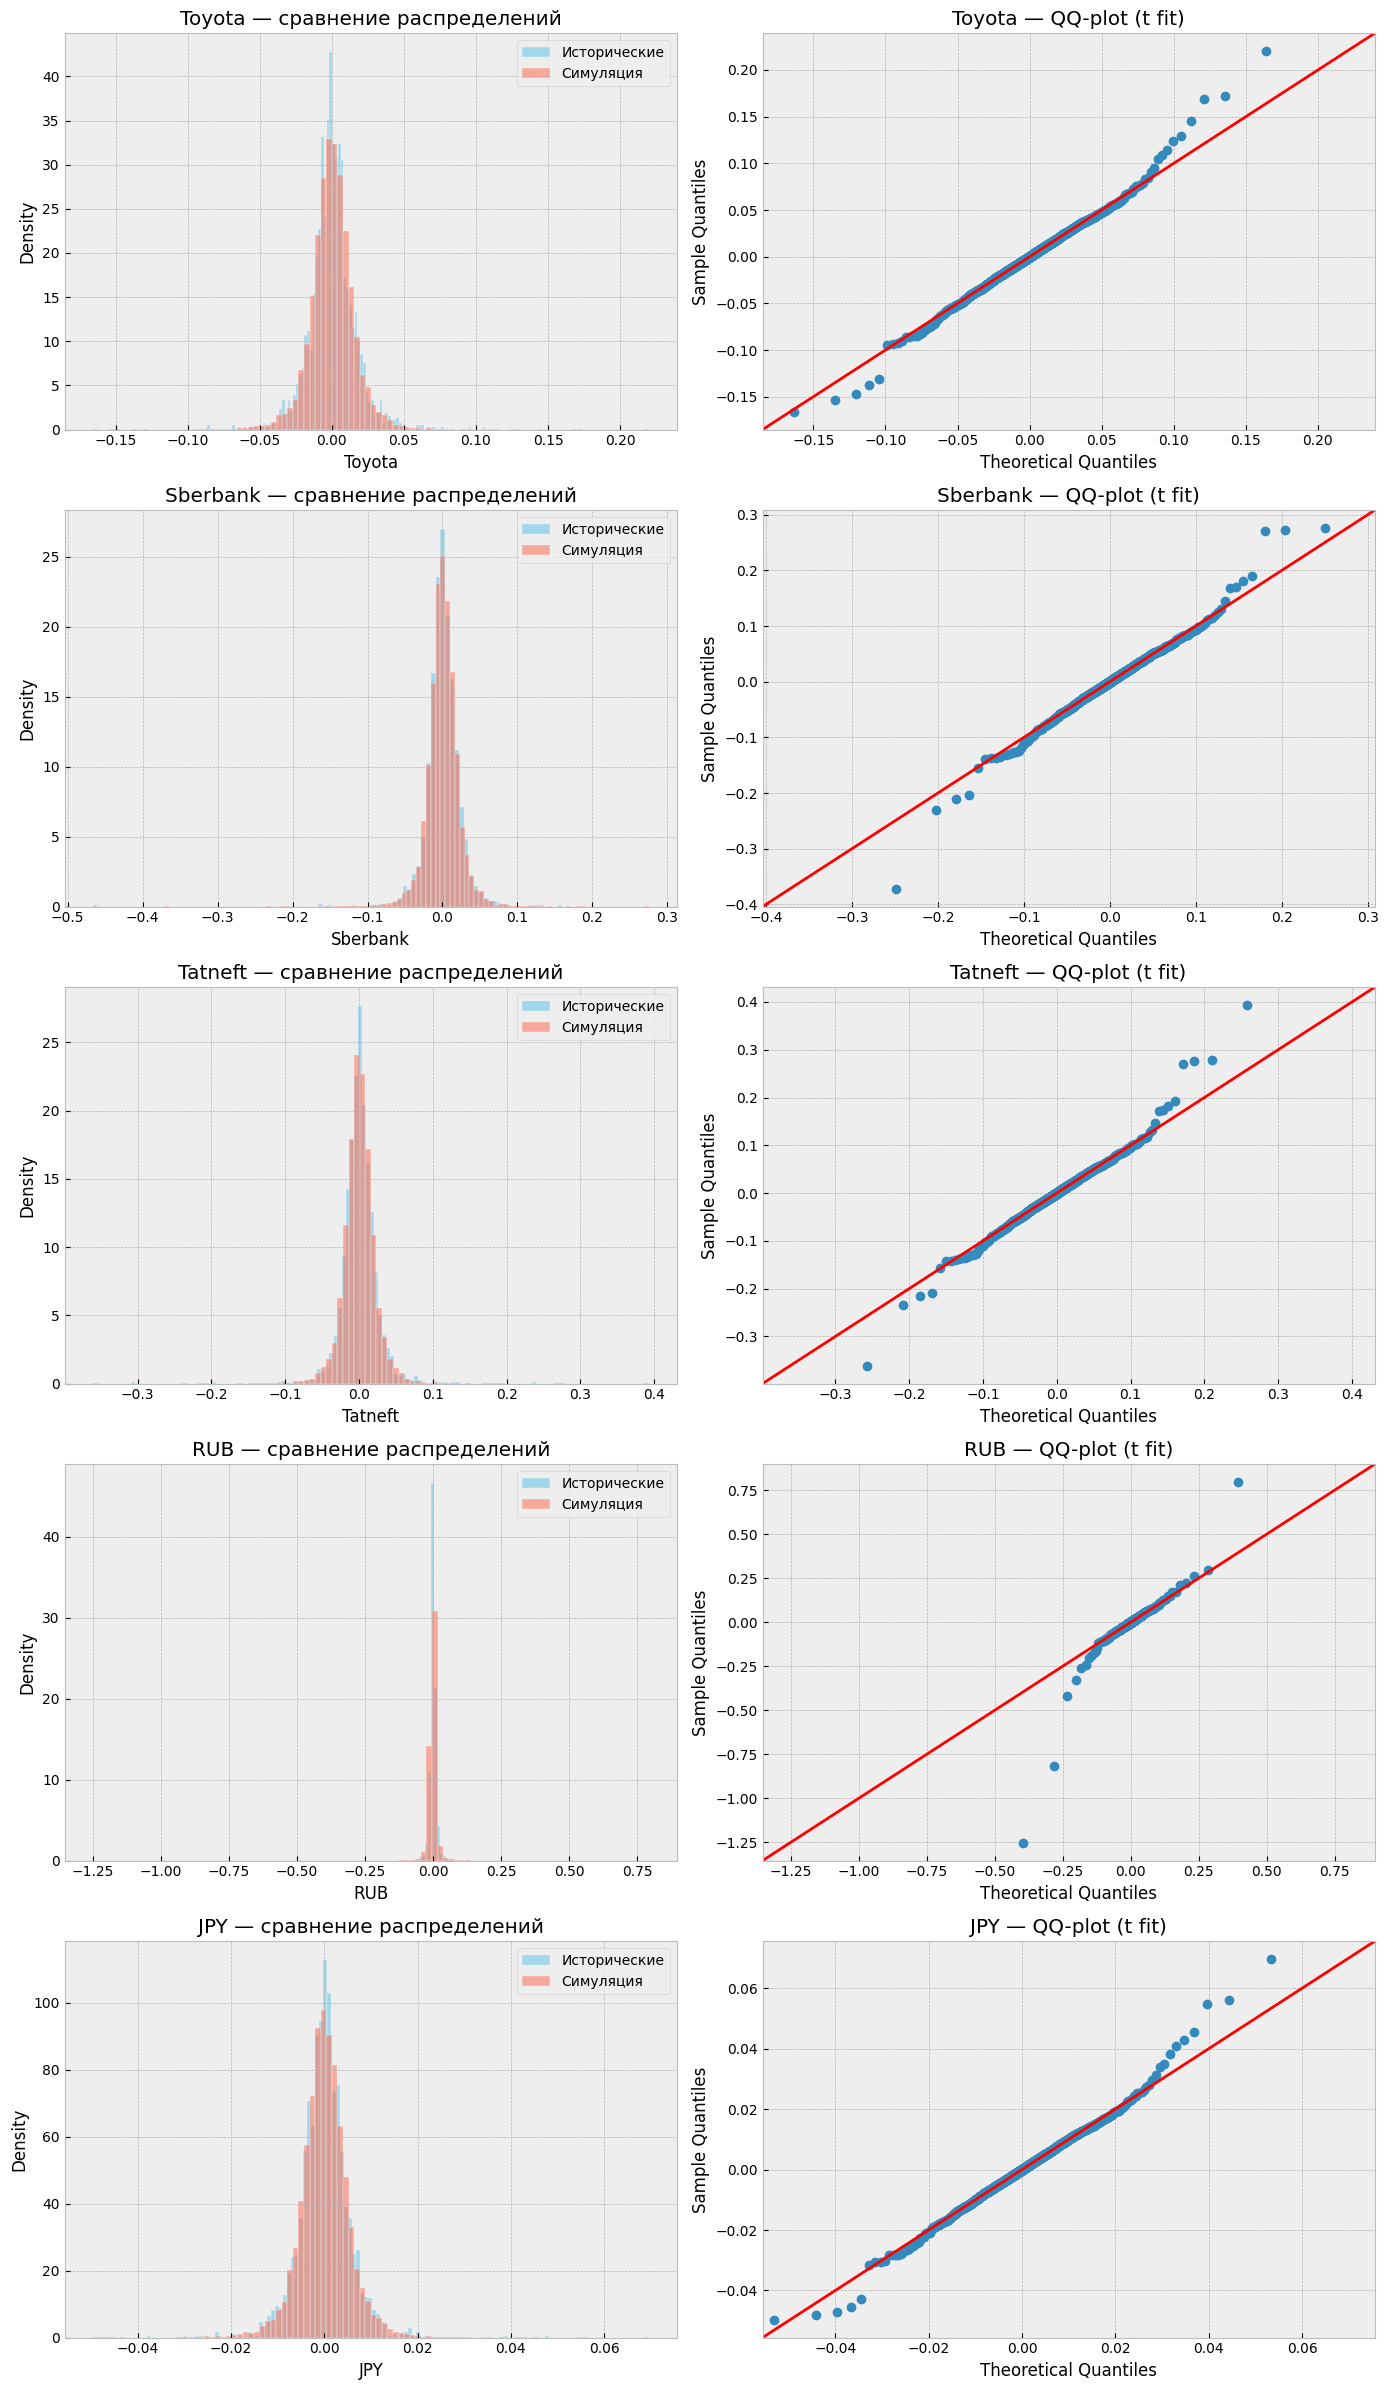

In [130]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 24))
axes = axes.reshape(-1, 2)

for i, col in enumerate(returns.columns):
    real_data = returns[col].dropna()
    sim_data = return_simulations[col]

    sns.histplot(real_data, bins=100, stat='density', ax=axes[i, 0], color='skyblue', label='Исторические')
    sns.histplot(sim_data, bins=100, stat='density', ax=axes[i, 0], color='tomato', label='Симуляция', alpha=0.5)
    axes[i, 0].set_title(f"{col} — сравнение распределений")
    axes[i, 0].legend()
    axes[i, 0].grid(True)

    df, loc, scale = ss.t.fit(sim_data)
    qqplot(sim_data, line='45', dist=ss.t, distargs=(df,), loc=loc, scale=scale, ax=axes[i, 1])
    axes[i, 1].set_title(f"{col} — QQ-plot (t fit)")
    axes[i, 1].grid(True)

plt.tight_layout()
plt.show()


1. Toyota
* Гистограмма: t-распределение хорошо описывает форму, включая центр и хвосты.
* QQ-график: точки ложатся почти на линию, особенно в центре. Лёгкие отклонения в хвостах.
2. Sberbank
* Гистограмма: визуальное совпадение достаточно хорошее, включая асимметрию.
** QQ-график: t-распределение гораздо лучше приближает хвосты, чем нормальное (это спойлер на следующий блок).
5. JPY
* Гистограмма и QQ-плот показывают, что t-распределение адекватно описывает и центр, и хвосты.

RUB страдают особенно сейчас. Татнефть, в принципе, нормально, но еще глянем гарч потом.

### Нормальное

In [131]:
n_samples = 10_000
return_simulations_normal = {}

for col in returns.columns:
    clean_data = returns[col].dropna()
    mu, sigma = clean_data.mean(), clean_data.std()
    return_simulations_normal[col] = ss.norm.rvs(loc=mu, scale=sigma, size=n_samples, random_state=42)

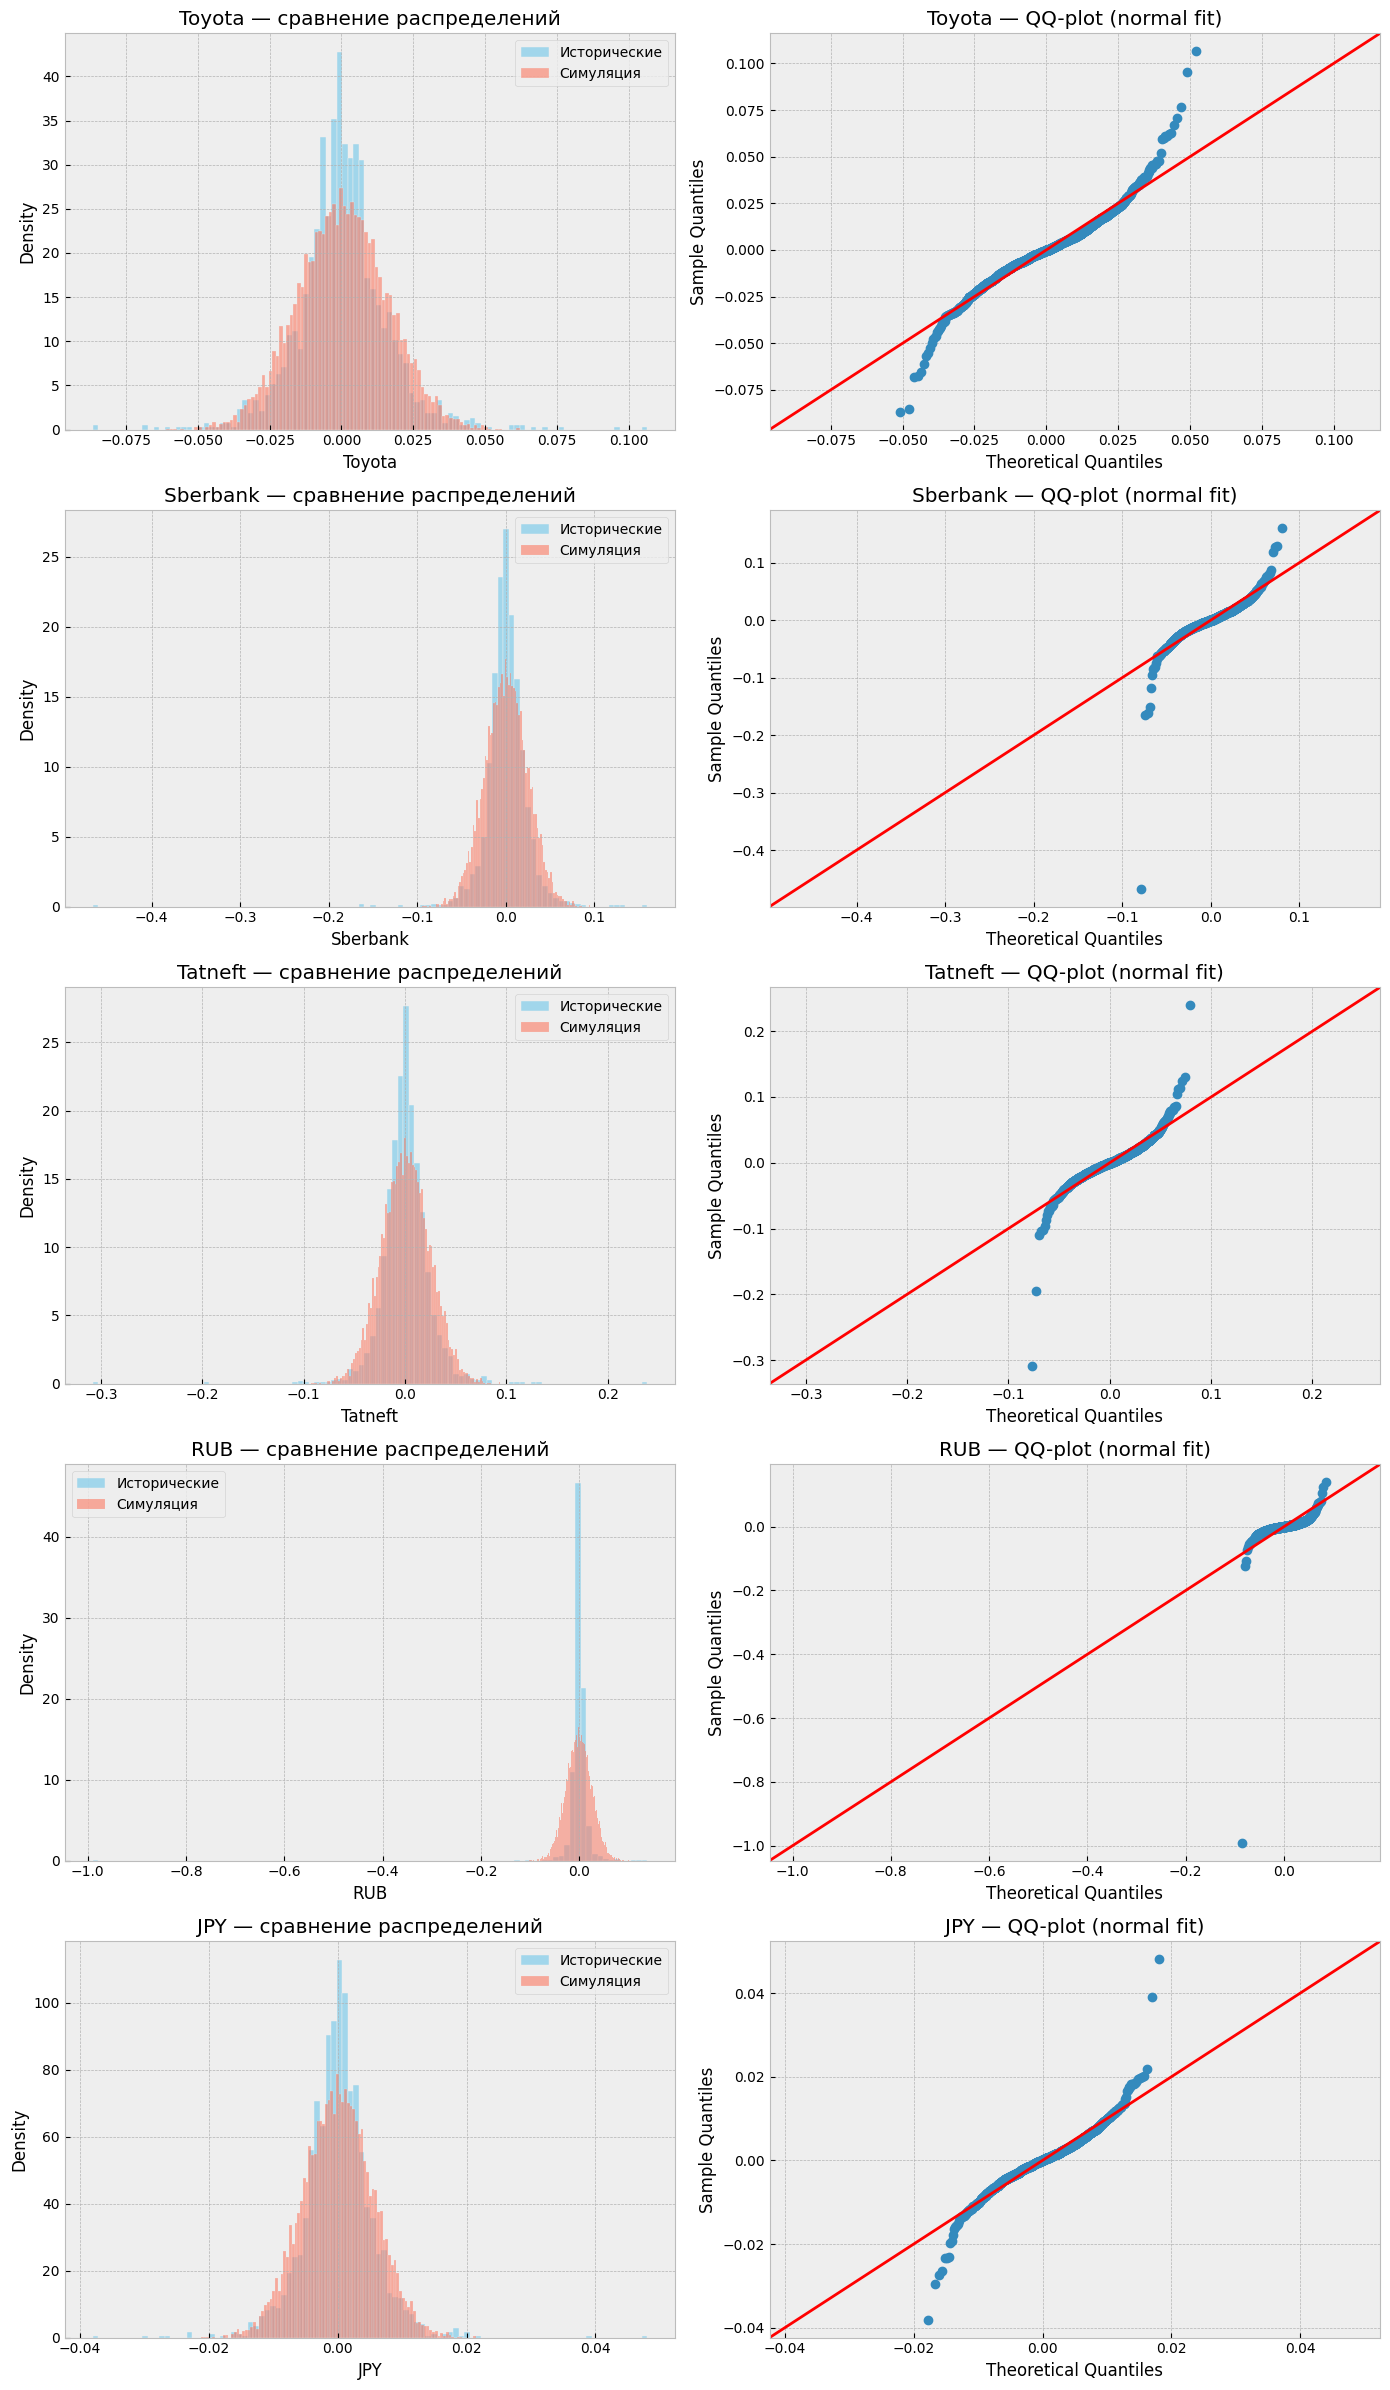

In [132]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 24))
axes = axes.reshape(-1, 2)

for i, col in enumerate(returns.columns):
    real_data = returns[col].dropna()
    sim_data = return_simulations_normal[col]

    sns.histplot(real_data, bins=100, stat='density', ax=axes[i, 0], color='skyblue', label='Исторические')
    sns.histplot(sim_data, bins=100, stat='density', ax=axes[i, 0], color='tomato', label='Симуляция', alpha=0.5)
    axes[i, 0].set_title(f"{col} — сравнение распределений")
    axes[i, 0].legend()
    axes[i, 0].grid(True)

    mu, sigma = real_data.mean(), real_data.std()
    qqplot(real_data, line='45', dist=ss.norm, loc=mu, scale=sigma, ax=axes[i, 1])
    axes[i, 1].set_title(f"{col} — QQ-plot (normal fit)")
    axes[i, 1].grid(True)
plt.tight_layout()
plt.show()

Трешик, нет, здесь вообще мимо все и сразу. Нормальное распределение плохо описывает хвосты и экстремальные движения всех активов. Особенно сильны отклонения у рубля и Татнефти.

Рассмотрим еще другие варианты.

### Гарч

In [122]:
!pip install arch

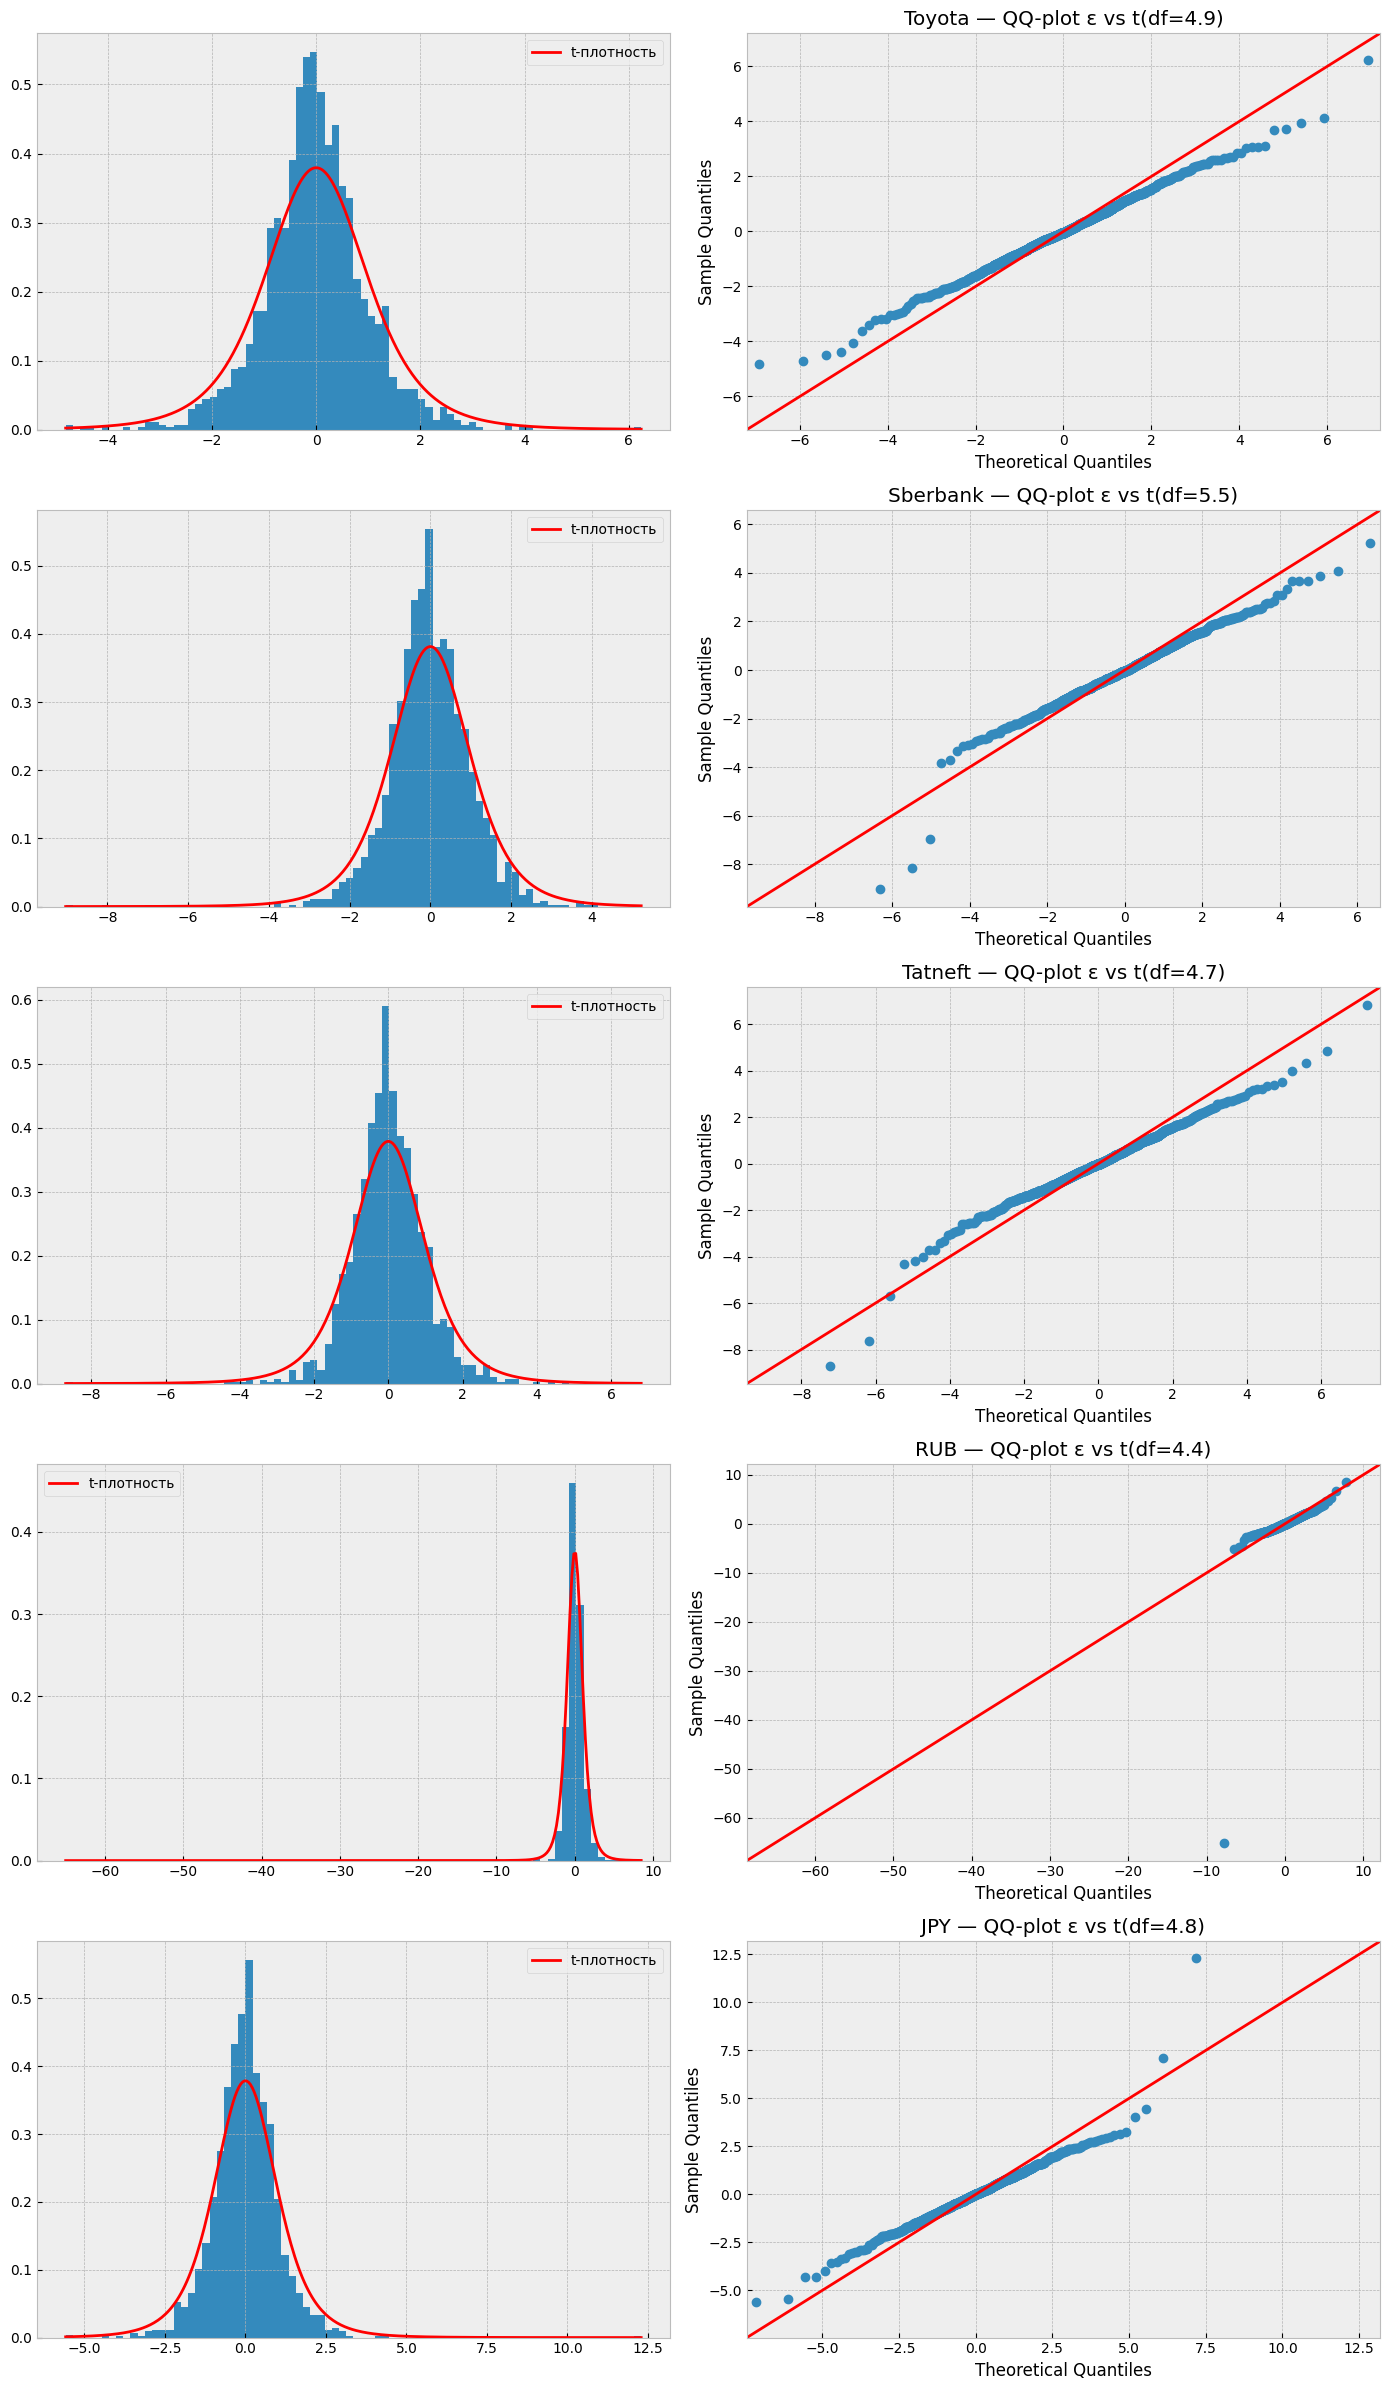

In [127]:
from arch import arch_model
from statsmodels.graphics.gofplots import qqplot

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 24))
axes = axes.reshape(-1, 2)

for i, col in enumerate(returns.columns):
    y = returns[col].dropna() * 100

    model = arch_model(y, vol='GARCH', p=1, q=1, dist='t')
    res = model.fit(disp='off')

    eps = res.std_resid.dropna()

    df = res.params["nu"]
    x = np.linspace(eps.min(), eps.max(), 300)
    pdf = ss.t.pdf(x, df)

    axes[i, 0].hist(eps, bins=80, density=True)
    axes[i, 0].plot(x, pdf, 'r-', label='t-плотность')
    axes[i, 0].legend()

    qqplot(eps, line='45', dist=ss.t, distargs=(df,), ax=axes[i, 1])
    axes[i, 1].set_title(f"{col} — QQ-plot ε vs t(df={df:.1f})")
    axes[i, 1].grid(True)

plt.tight_layout()
plt.show()

* Toyota, Sberbank, Tatneft, JPY:
Остатки хорошо описываются t-распределением с 4.7–5.5 степенями свободы — есть небольшие отклонения в хвостах, но центр и форма распределения в целом адекватны.
* RUB:
Очень узкое распределение остатков, пик и длинные хвосты. QQ-график показывает резкое отклонение в отрицательном хвосте. Это может говорить о структурной особенности данных, мб, например, интервенции, административное управление курсом и тд.

### 4) Копулы
Мы знаем, что по-отдельности инструменты моделируются довольно легко. Однако так как мы рассматриваем портфель, акции и валюты могут быть скоррелированы. Особенно в случае, когда ваши акции взяты из похожих компаний. Поэтому нам бы хотелось иметь метод, который хорошо учитывает такие зависимости в совокупности. Копулы -- один из таких способов. Ваша последовательность действий будет выглядеть следующим образом:

Пусть мы имеем историю доходностей 5 инструментов за предыдущие 10 лет (условно 365*10 = 3650 наблюдений). Пусть мы хотим сделать прогноз VaR на один шаг вперёд. Представим данные в виде таблицы $3650\times5$

1. Используем найденные в предыдущем пункте распределения. Для каждого из инструментов прогоним доходности через фукнцию распределения. Для GARCH нужно будет предварительно получить стандартизированные остатки, так как распределение оценивается именно для них. Получим вектор той же длины, но уже в диапазоне [0, 1]. Получим таблицу аналогичной размерности, $3650\times5$. По сути, мы переходим в новое признаковое пространство, в котором нам легко оценить и просимулировать распределение с очень сложными зависимостями.

2. Оценим на этой матрице копулу. Выберем наилучшую копулу по AIC.

3. Произведём симуляции из копулы. Так как копула будет иметь размерность 5, то выходная матрица симуляций будет иметь размер $n\_sim\times5$. Ожидается, что компоненты этой симуляции будут коррелированы соответственно исходным данным.

4. Для каждого из пяти инструментов в симуляции проведём обратное преобразование. Для этого используем обратную функцию распределения. Для GARCH нужно будет дополнительно использовать прогнозы матожидания и дисперсии. Получим всё также матрицу $n\_sim\times5$.

5. Далее для подсчёта VaR можно просто взвесить доходности отдельных компонент обратно в портфель и взять от этого квантиль. Для подсчёта ES можно взять математичечкое ожидание доходностей портфеля, которые меньше VaR. Используйте 5%-й VaR.

Используйте одну копулу. Для простоты давайте ограничимся [Архимедовыми копулами](https://copulae.readthedocs.io/en/latest/api_reference/copulae/archimedean/index.html). Они имеют минимум параметров и быстро оцениваются. Не пытайтесь выполнить это задание с эллиптическими копулами (гауссова, стьюдента). Они оцениваются очень долго и вы устанете считать.

Начнём с простого и будем работать со всеми данными сразу.


#### 4.1 (1 балл)
Проведите преобразование, переводящее доходности на единичный куб. Воспользуйтесь функциями распределения из пункта 4. Опять же, обратите внимание, что GARCH необходимо обрабатывать отдельно и работать с распределением стандартизированных остатков.

In [147]:
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1987 entries, 2014-01-08 to 2022-05-24
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Toyota    1987 non-null   float64
 1   Sberbank  1987 non-null   float64
 2   Tatneft   1987 non-null   float64
 3   RUB       1986 non-null   float64
 4   JPY       1987 non-null   float64
dtypes: float64(5)
memory usage: 93.1 KB


In [146]:
from scipy.stats import t, norm, gennorm

marginals = {
    "Toyota": {"type": "garch_t"},
    "Sberbank": {"type": "t"},
    "Tatneft": {"type": "garch_t"},
    "RUB": {"type": "garch_t"},
    "JPY": {"type": "t"}
}

u = {}

for col in returns.columns:
    x = returns[col].dropna() * 100

    if marginals[col]["type"] == "garch_t":
        g = arch_model(x, vol="Garch", p=1, q=1, dist="t").fit(disp="off")
        eps = g.std_resid.dropna()
        df  = g.params["nu"]
        u[col] = pd.Series(t.cdf(eps, df=df), index=eps.index)

    elif marginals[col]["type"] == "t":
        df, loc, scale = t.fit(x)
        u[col] = pd.Series(t.cdf(x, df, loc, scale), index=x.index)

    elif marginals[col]["type"] == "norm":
        mu, sigma = x.mean(), x.std()
        u[col] = pd.Series(norm.cdf(x, loc=mu, scale=sigma), index=x.index)

u_df = pd.concat(u, axis=1).dropna()
print(u_df.shape)
u_df.head(3)

(1986, 5)


,Toyota,Sberbank,Tatneft,RUB,JPY
Date,,,,,
2014-01-08,0.486205,0.372328,0.147924,0.381833,0.311645
2014-01-09,0.378612,0.422118,0.677258,0.471712,0.612836
2014-01-10,0.561051,0.804267,0.643144,0.629854,0.476590


#### 4.2 (1 балл)

Используйте пакет [copulae](https://pypi.org/project/copulae/). Подберите по AIC Архимедовы копулы. Выберите одну из двух опций:
1. Выберите лучшую копулу на всех доходностях.  (0.5 балла)
2. Выберите две отдельные копулы. Одна на валюты, одна на акции. (1 балл)


In [159]:
!pip install copulae

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 44.7 MB/s eta 0:00:00


In [169]:
from copulae.archimedean import ClaytonCopula, FrankCopula, GumbelCopula

U = np.clip(u_df.to_numpy(), 1e-6, 1 - 1e-6)
dim = U.shape[1]

candidates = {
    "Clayton": ClaytonCopula(dim=dim),
    "Frank"  : FrankCopula(dim=dim),
    "Gumbel" : GumbelCopula(dim=dim)
}

results = []
for name, cop in candidates.items():
    cop.fit(U)
    ll = cop.log_lik(U)
    aic = 2 - 2 * ll
    results.append((name, cop, ll, aic))

results.sort(key=lambda x: x[3])

print("AIC-рейтинг:")
for name, cop, ll, aic in results:
    print(f"{name:7s}  logL = {ll:9.1f}   AIC = {aic:8.1f}")

best_name, best_cop, *_ = results[0]

AIC-рейтинг:
Clayton  logL =      77.9   AIC =   -153.8
Frank    logL =      67.4   AIC =   -132.8
Gumbel   logL =      63.0   AIC =   -124.0


Причиной победы Clayton-копулы является, что данные обладают сильной ко-зависимостью при экстремально низких значениях переменных — например, в ситуациях совместного падения отрасли. Такая асимметрия характерна для финансовых временных рядов.

#### 4.3 (1 балл)
Просимулируйте с помощью копулы ваши инструменты. Для любой пары инструментов нарисуйте четыре scatter-plot в ряд:

1. Исходные доходности
2. Доходности, переведённые на единичный куб
3. Просимулированные доходности на единичном кубе
4. Просимулированные доходности, переведённые в исходные величины

Графики 1/4 и 2/3 должны иметь примерно одинаковые зависимости.

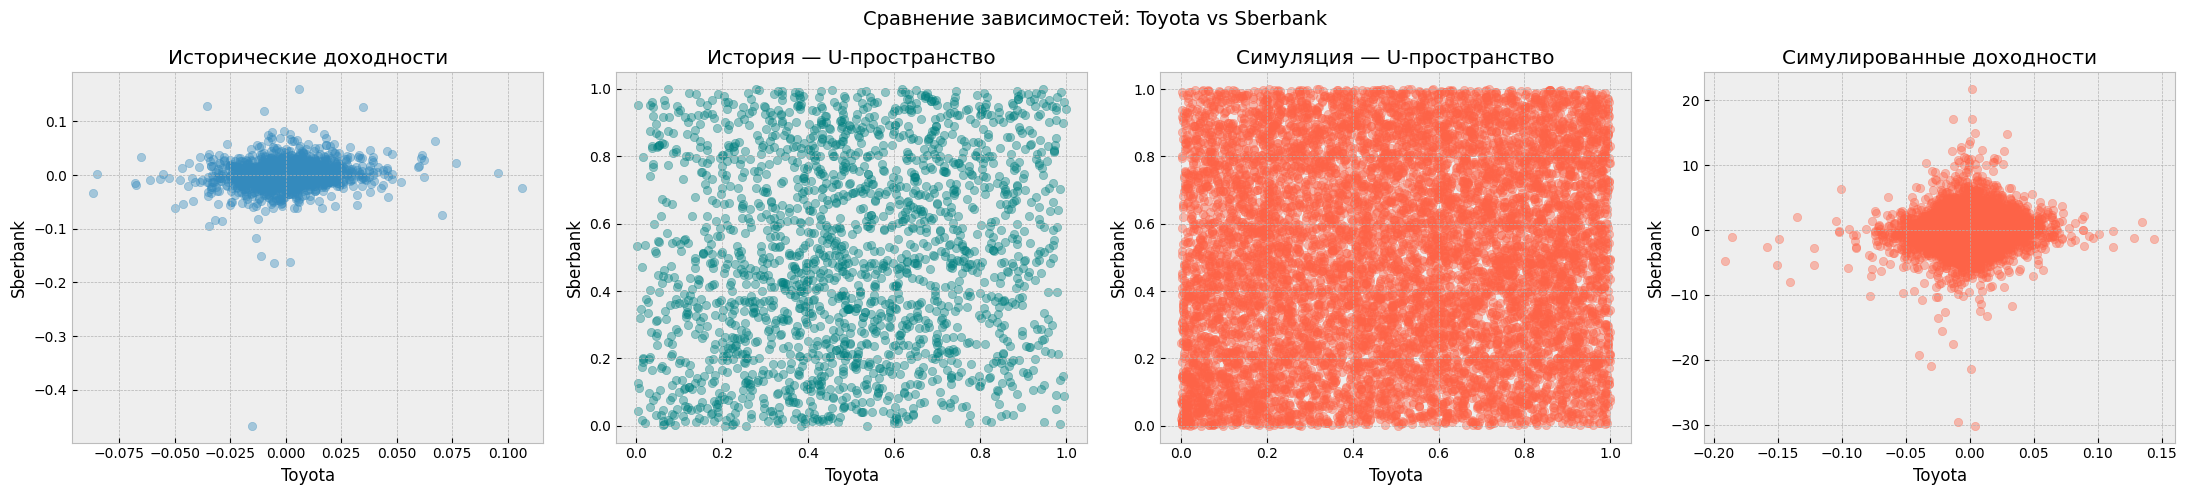

In [188]:
pair = ["Toyota", "Sberbank"]

U_hist   = u_df[pair].values
U_sim    = best_cop.random(10_000)[:, [u_df.columns.get_loc(c) for c in pair]]

spec = {"Toyota": "garch_t", "Sberbank": "t"}

def inverse(col, u):
    x = returns[col].dropna() * 100
    if spec[col] == "garch_t":
        g = arch_model(x, vol="Garch", p=1, q=1, dist="t").fit(disp="off")
        df = g.params["nu"]
        eps = t.ppf(u, df)
        mu  = g.params["mu"]
        h   = g.conditional_volatility.iloc[-1]
        return (mu + np.sqrt(h)*eps) / 100
    elif spec[col] == "t":
        df, loc, scale = t.fit(x)
        return t.ppf(u, df, loc, scale)
    else:
        mu, sigma = x.mean(), x.std()
        return norm.ppf(u, mu, sigma)

ret_sim = pd.DataFrame({c: inverse(c, U_sim[:, k]) for k, c in enumerate(pair)})


ret_hist = returns[pair]
fig, ax = plt.subplots(1, 4, figsize=(22, 5))

ax[0].scatter(ret_hist[pair[0]], ret_hist[pair[1]], alpha=0.4)
ax[0].set_title("Исторические доходности")

ax[1].scatter(U_hist[:, 0], U_hist[:, 1], color="teal", alpha=0.4)
ax[1].set_title("История — U-пространство")

ax[2].scatter(U_sim[:, 0], U_sim[:, 1], color="tomato", alpha=0.4)
ax[2].set_title("Симуляция — U-пространство")

ax[3].scatter(ret_sim[pair[0]], ret_sim[pair[1]], color="tomato", alpha=0.4)
ax[3].set_title("Симулированные доходности")

for a in ax:
    a.set_xlabel(pair[0]); a.set_ylabel(pair[1]); a.grid(True)

plt.suptitle("Сравнение зависимостей: Toyota vs Sberbank", fontsize=14)
plt.tight_layout(); plt.show()


1. Исторические доходности (1):
Видна слабая ну или даже нулевая зависимость между доходностями Toyota и Сбербанка. Распределение плотное в центре, присутствуют выбросы.

2. Исторические доходности в U-пространстве:
Преобразование доходностей в единичный квадрат с помощью эмпирической функции распределения. Это подготавливает данные для подгонки копулы - тк все значения между 0 и 1

3. Смоделированные данные в U-пространстве:
Сэмплы, сгенерированные из подобранной копулы (Clayton).
Сохранена структура зависимостей, похоже на фото 2, не знаю что еще добавить тут.

4. Смоделированные доходности (обратно в исходное пространство):
Сохранена форма исходного облака.

### 5) VaR и ES (1 балл)

С помощью выбранных распределений и копул вычислите VaR-кривую и ES-кривую. Можно ориентироваться на функцию с семинара 12. Модифицируйте её для подсчёта ES. Если вы использовали альтернативную стратегию взвешивания, также учтите это.

In [229]:
def copula_sampler_clayton(history, n_samples=2000):
    cols = history.columns

    U = np.column_stack([t.cdf(history[c], *t.fit(history[c])) for c in cols])

    cop = ClaytonCopula(dim=len(cols)); cop.fit(U)
    U_sim = cop.random(n_samples)

    sim = {c: t.ppf(U_sim[:, k], *t.fit(history[c])) for k, c in enumerate(cols)}
    return pd.DataFrame(sim)

In [234]:
from tqdm import tqdm

In [235]:
def calc_VaR(r, sampling_fun, w, L_history=252, level=0.05):
    VaR = np.full(r.shape[0], np.nan)
    ES  = np.full(r.shape[0], np.nan)

    for i in tqdm(range(L_history, r.shape[0])):
        hist = r.iloc[i-L_history:i]
        try:
            sim = sampling_fun(hist)
            port_sim = sim.dot(w)
            var_i = np.quantile(port_sim, level)
            VaR[i] = var_i
            ES[i]  = port_sim[port_sim < var_i].mean()
        except Exception:
            VaR[i] = VaR[i-1]; ES[i] = ES[i-1]

    idx = r.index
    return pd.Series(VaR, idx, name='VaR'), pd.Series(ES, idx, name='ES')


### 6) Визуализация (0.5 балла)

Визуализируйте VaR и ES на графике с доходностями.

  !!! ОСТОРОЖНО РАБОТАЕТ 10 МИНУТ

In [236]:
r_portfolio = returns[selected_companies] @ w_temp

VaR_series, ES_series = calc_VaR(
    r=returns[selected_companies],
    sampling_fun=copula_sampler_clayton,
    w=w_temp,
    level=alpha
)

100%|██████████| 1735/1735 [09:30<00:00,  3.04it/s]


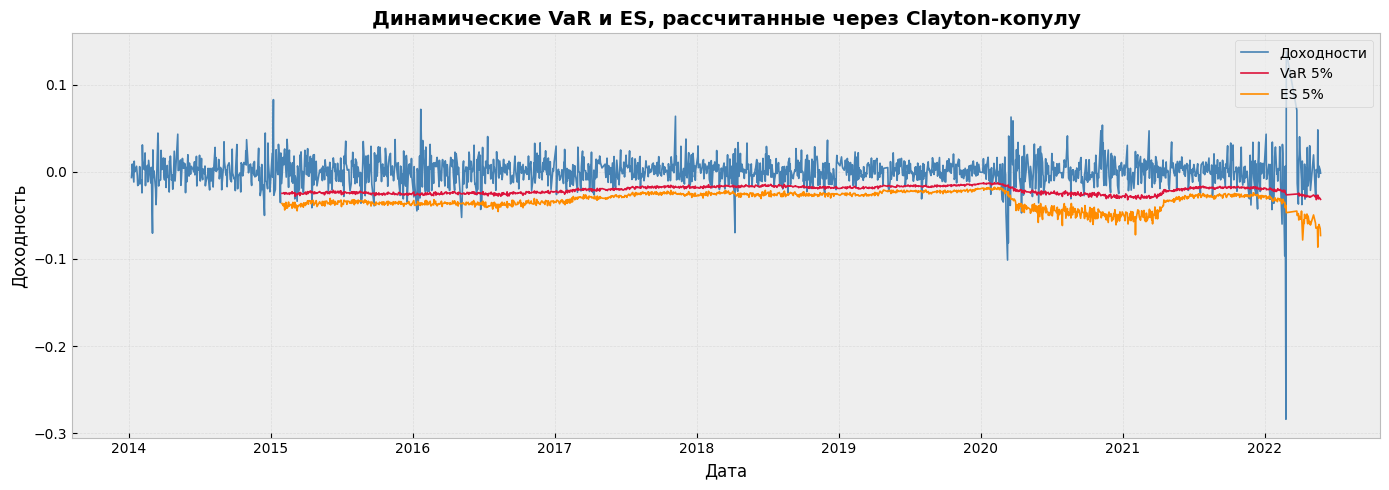

In [239]:
def plot_var_es(portfolio_returns, VaR, ES, title="VaR & ES vs Returns"):
    plt.figure(figsize=(14, 5))
    sns.lineplot(data=portfolio_returns, label="Доходности", linewidth=1.2, color="steelblue")
    sns.lineplot(data=VaR,  label="VaR 5%",  linewidth=1.2, color="crimson")
    sns.lineplot(data=ES,   label="ES 5%",   linewidth=1.2, color="darkorange")

    breach = portfolio_returns < VaR

    plt.title(title, fontweight="bold")
    plt.xlabel("Дата"); plt.ylabel("Доходность")
    plt.legend(loc="upper right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_var_es(r_portfolio, VaR_series, ES_series,
            title="Динамические VaR и ES, рассчитанные через Clayton-копулу")

В периоды рыночного спокойствия линии VaR и ES почти параллельны и близки друг к другу. В кризисные периоды (например, 2020) видно значительное углубление VaR и ES.

### 7) Бектестинг. (1 балл)

Проведите тесты на покрытие и независимость для VAR-кривой. Добейтесь того, чтобы тесты успешно проходились, без этого пункт не засчитывается. Если потребуется, вернитесь к подбору частных распределений.

In [ ]:
from scipy.stats import chi2

def bern_test(p, v):
    lv = len(v)
    sv = sum(v)
    al = np.log(p) * sv + np.log(1 - p) * (lv - sv)
    bl = np.log(sv / lv) * sv + np.log(1 - sv / lv) * (lv - sv)
    return -2 * (al - bl)

def ind_test(V):
    J = np.full((len(V), 4), 0)
    for i in range(1, len(V) - 1):
        J[i, 0] = (V[i - 1] == 0) & (V[i] == 0)
        J[i, 1] = (V[i - 1] == 0) & (V[i] == 1)
        J[i, 2] = (V[i - 1] == 1) & (V[i] == 0)
        J[i, 3] = (V[i - 1] == 1) & (V[i] == 1)

    V_00 = J[:, 0].sum()
    V_01 = J[:, 1].sum()
    V_10 = J[:, 2].sum()
    V_11 = J[:, 3].sum()

    p_00 = V_00 / (V_00 + V_01) if (V_00 + V_01) > 0 else 1e-6
    p_01 = V_01 / (V_00 + V_01) if (V_00 + V_01) > 0 else 1e-6
    p_10 = V_10 / (V_10 + V_11) if (V_10 + V_11) > 0 else 1e-6
    p_11 = V_11 / (V_10 + V_11) if (V_10 + V_11) > 0 else 1e-6
    hat_p = (V_01 + V_11) / (V_00 + V_01 + V_10 + V_11)

    al = np.log(1 - hat_p) * (V_00 + V_10) + np.log(hat_p) * (V_01 + V_11)
    bl = np.log(p_00) * V_00 + np.log(p_01) * V_01 + np.log(p_10) * V_10 + np.log(p_11) * V_11
    return -2 * (al - bl)

In [247]:

def backtest_results(ret, var_curve, alpha=0.05, significance=0.95):
    idx = var_curve.notna()
    ret = ret[idx]
    var_curve = var_curve[idx]

    violations = (ret < var_curve).astype(int)

    LR_cov = bern_test(alpha, violations)
    passed_cov = LR_cov < chi2.ppf(significance, df=1)

    LR_ind = ind_test(violations)
    passed_ind = LR_ind < chi2.ppf(significance, df=1)

    print(f"Target share of violations: {100 * alpha:.2f}%")
    print(f"Observed share of violations: {100 * violations.mean():.2f}%\n")

    print(f"Coverage Test: {'PASSED' if passed_cov else 'FAILED'} (LR={LR_cov:.2f}, p-thresh={chi2.ppf(significance, 1):.2f})")
    print(f"Independence Test: {'PASSED' if passed_ind else 'FAILED'} (LR={LR_ind:.2f}, p-thresh={chi2.ppf(significance, 1):.2f})")

    print(f"\nResult: {'OK' if passed_cov and passed_ind else 'Not passed'}")


In [248]:
backtest_results(r_portfolio, VaR_series, alpha=0.05)

Target share of violations: 5.00%
Observed share of violations: 5.36%

Coverage Test: PASSED (LR=0.46, p-thresh=3.84)
Independence Test: FAILED (LR=15.43, p-thresh=3.84)

Result: ❌ Not passed


Анлак(((

##### Рубрика "как вам домашка?" (0.1 балла)

Пройдите короткий опрос. Это действительно важно. https://forms.gle/w3sV453spERTbGvr7